Описание задачи

Разработка модели машинного обучения, которая будет предсказывать риск сердечного приступа.

Признаки следующие:
- Age - возраст
- Cholesterol - показатель холестерина 
- Heart rate - частота сердцебиения
- Diabetes - наличие диабета
- Family History - есть ли у пациента в семье проблемы с сердцем
- Smoking - курит ли пациент
- Obesity - есть ли ожирение
- Alcohol Consumption - употребление алкоголя
- Exercise Hours Per Week - количество часов занятий спортом в неделю
- Diet - диета
- Previous Heart Problems - наличие проблем с сердцем у пациента
- Medication Use - использование лекарств
- Stress Level - уровень стресса
- Sedentary Hours Per Day - количество часов в сидячем положении в день
- Income - доход
- BMI - индекс массы тела
- Triglycerides - Уровень триглицеридов
- Physical Activity Days Per Week - Дней физической активности в неделю
- Sleep Hours Per Day - Количество часов сна в день
- Heart Attack Risk (Binary) - Риск сердечного приступа (двоичный, целевой признак)
- Blood sugar - Уровень сахара в крови
- CK-MB - Уровень фермента креатинкиназы
- Troponin - Уровень тропонина
- Gender - Пол
- Systolic blood pressure - Систолическое артериальное давление
- Diastolic blood pressure - Диастолическое артериальное давление
- id - идентификатор пациента

Данные до нас были отмасштабированы

Целью будет модель, которая будет предсказывать риск сердечного приступа, у которой будут минимизированы пропуски рисковых пациентов

In [54]:
RANDOM_STATE=42
TEST_SIZE=0.25

In [55]:
# !pip install lightgbm

In [81]:
import os
import sys
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from ydata_profiling import ProfileReport
from phik import phik_matrix

from imblearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import (
    RandomizedSearchCV,
    train_test_split,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [82]:
heart_data = pd.read_csv('heart_train.csv')

In [83]:
heart_data.head()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


In [84]:
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

In [85]:
heart_data.describe()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Systolic blood pressure,Diastolic blood pressure,id
count,8685.000000,8685.000000,8685.000000,8685.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8685.000000,...,8685.000000,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000
mean,4342.000000,0.449958,0.501070,0.050658,0.652097,0.489576,0.902867,0.498342,0.601990,0.503378,...,0.505484,3.508292,0.503737,0.346920,0.227339,0.048159,0.036689,0.450295,0.497634,4831.210823
std,2507.287877,0.231174,0.284716,0.023453,0.476333,0.499921,0.296157,0.500027,0.489517,0.284810,...,0.286320,2.281772,0.328061,0.476017,0.076635,0.075531,0.060157,0.170184,0.171830,2782.585625
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2171.000000,0.258427,0.267857,0.034830,0.000000,0.000000,1.000000,0.000000,0.000000,0.263286,...,0.263636,2.000000,0.166667,0.000000,0.227018,0.048229,0.036512,0.303226,0.348837,2425.000000
50%,4342.000000,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,0.000000,1.000000,0.502110,...,0.503603,3.000000,0.500000,0.000000,0.227018,0.048229,0.036512,0.445161,0.500000,4837.000000
75%,6513.000000,0.640449,0.746429,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.748709,...,0.750649,6.000000,0.833333,1.000000,0.227018,0.048229,0.036512,0.600000,0.651163,7242.000000
max,8684.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9650.000000


Выделим следующие проблемы:

- Поскольку у первого столбца не было названия, он автоматически назвался Unnamed: 0. Удалим этот столбец
- Также есть столбец id. Его до матрицы корреляции удалять не будем.
- Есть признаки, которые могли быть получены только после сердечного приступа: Тропонин и СК-МВ
- В столбце с полом есть несколько строк с уже закодированными значениями, пока остальные строки остаются незакодированными
- Также есть проблема с типами данных
- Есть неинформативный столбец с доходом
- Как будто стоит удалить признак о приеме медикаментов, как будто он означает, принимает ли пациент таблетки для сердца

Я бы начал с того, что посмотрел сразу все данные, практически без обработки, поскольку есть подозрение, что данные синтетические. Удалю только неназванный столбюец, поправлю столбец Gender и изменю типы данных

In [86]:
heart_data.drop('Unnamed: 0', axis=1, inplace=True)

In [87]:
heart_data.query('Gender != 0 and Gender != 1', inplace=True)

In [88]:
heart_data['Diabetes'] = heart_data['Diabetes'].astype('str')
heart_data['Family History'] = heart_data['Family History'].astype('str')
heart_data['Smoking'] = heart_data['Smoking'].astype('str')
heart_data['Obesity'] = heart_data['Obesity'].astype('str')
heart_data['Alcohol Consumption'] = heart_data['Alcohol Consumption'].astype('str')
heart_data['Diet'] = heart_data['Diet'].astype('str')
heart_data['Previous Heart Problems'] = heart_data['Previous Heart Problems'].astype('str')
heart_data['Heart Attack Risk (Binary)'] = heart_data['Heart Attack Risk (Binary)'].astype('int')
heart_data['Gender'] = heart_data['Gender'].astype('str')

Построим матрицу корреляции

interval columns not set, guessing: ['Age', 'Cholesterol', 'Heart rate', 'Exercise Hours Per Week', 'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Heart Attack Risk (Binary)', 'Blood sugar', 'CK-MB', 'Troponin', 'Systolic blood pressure', 'Diastolic blood pressure', 'id']


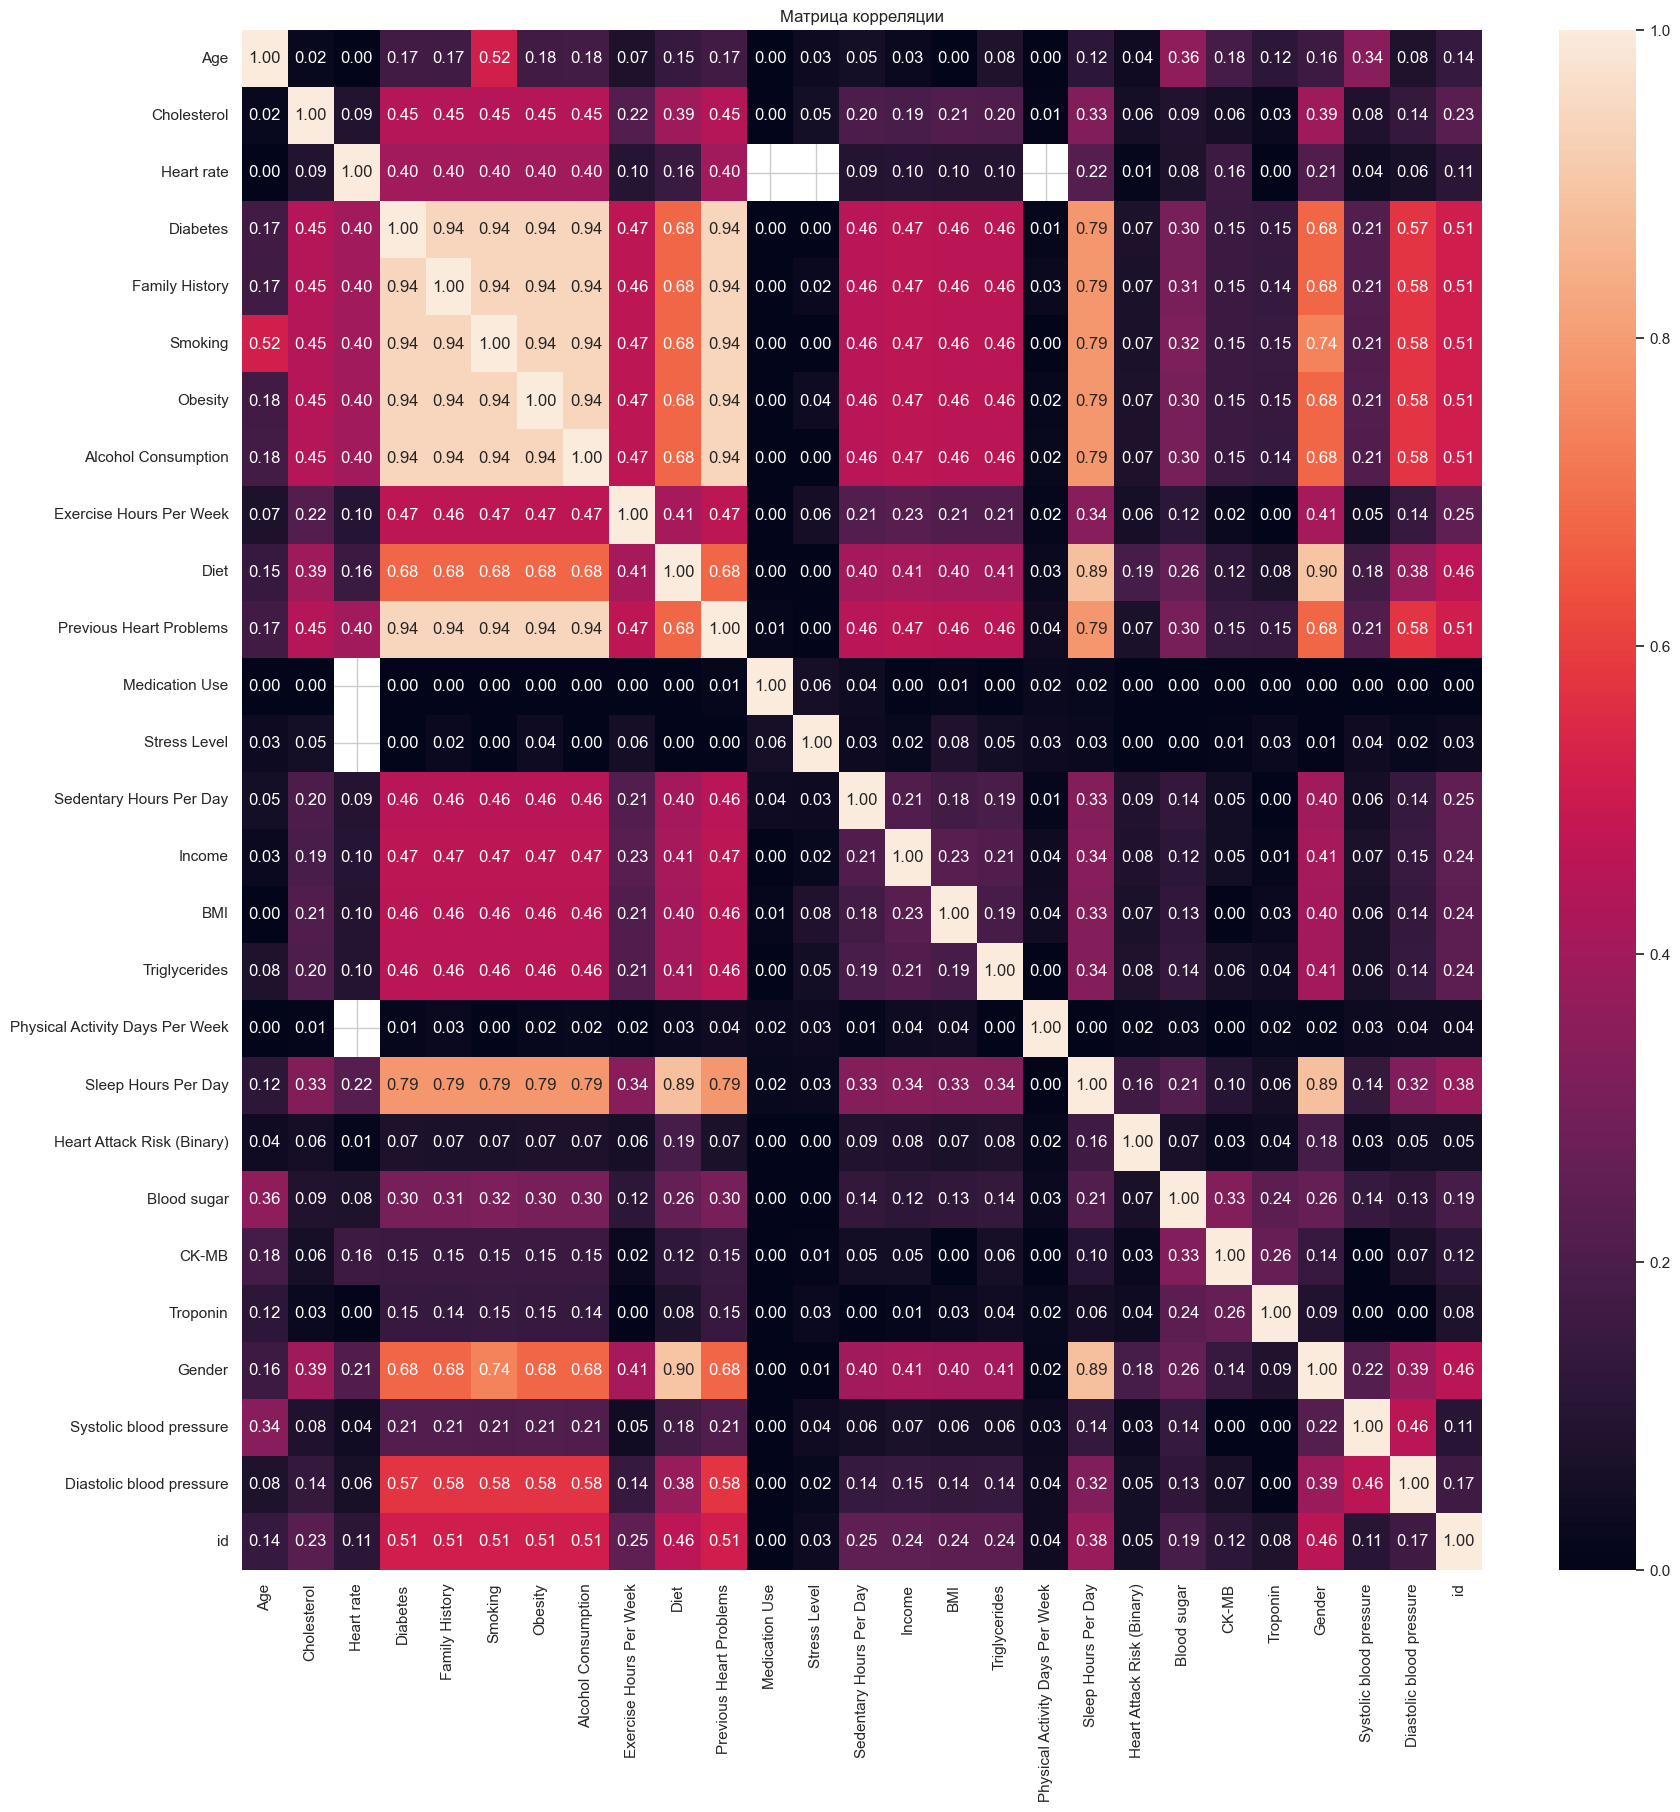

In [89]:
%matplotlib inline

corr_matrix = heart_data.phik_matrix()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title('Матрица корреляции')
plt.show()

Очень интересная матрица. Предположение о синтетических данных подтвердилось. 

Можно заметить, что данные условно говоря разделены по группам, например, признаки образа жизни.

Тем не менее, для чистоты эксперимента анализ и отбор признаков выполню так, как если бы данные были реальны, чтобы продемонстрировать процесс построения модели

In [91]:
heart_data.drop('id', axis=1, inplace=True)

In [92]:
heart_data.drop(['Medication Use'], axis=1, inplace=True)

In [93]:
heart_data.drop(['Troponin', 'CK-MB'], axis=1, inplace=True)

In [94]:
heart_data.drop('Income', axis=1, inplace=True)

#### Пропуски и дубликаты

Посмотрим на них

In [96]:
heart_data.isna().sum()

Age                                  0
Cholesterol                          0
Heart rate                           0
Diabetes                             0
Family History                       0
Smoking                              0
Obesity                              0
Alcohol Consumption                  0
Exercise Hours Per Week              0
Diet                                 0
Previous Heart Problems              0
Stress Level                       243
Sedentary Hours Per Day              0
BMI                                  0
Triglycerides                        0
Physical Activity Days Per Week    243
Sleep Hours Per Day                  0
Heart Attack Risk (Binary)           0
Blood sugar                          0
Gender                               0
Systolic blood pressure              0
Diastolic blood pressure             0
dtype: int64

In [97]:
heart_data.dropna(inplace=True)

In [98]:
heart_data.isna().sum()

Age                                0
Cholesterol                        0
Heart rate                         0
Diabetes                           0
Family History                     0
Smoking                            0
Obesity                            0
Alcohol Consumption                0
Exercise Hours Per Week            0
Diet                               0
Previous Heart Problems            0
Stress Level                       0
Sedentary Hours Per Day            0
BMI                                0
Triglycerides                      0
Physical Activity Days Per Week    0
Sleep Hours Per Day                0
Heart Attack Risk (Binary)         0
Blood sugar                        0
Gender                             0
Systolic blood pressure            0
Diastolic blood pressure           0
dtype: int64

Пропусков нет

Важно заметить, что у нас есть дисбаланс классов у тартега

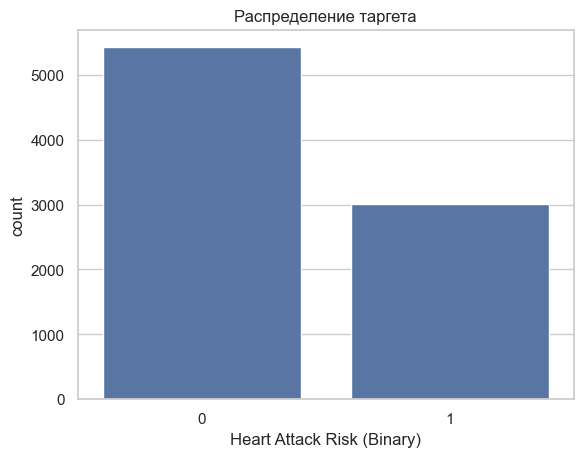

In [99]:
sns.countplot(heart_data, x='Heart Attack Risk (Binary)')
plt.title('Распределение таргета')
plt.show()

Как мы видим, пациентов без риска практически в 2 раза больше.

Из репорта также замечаем, что очень странно выглядит Blood sugar. Удалим этот признак

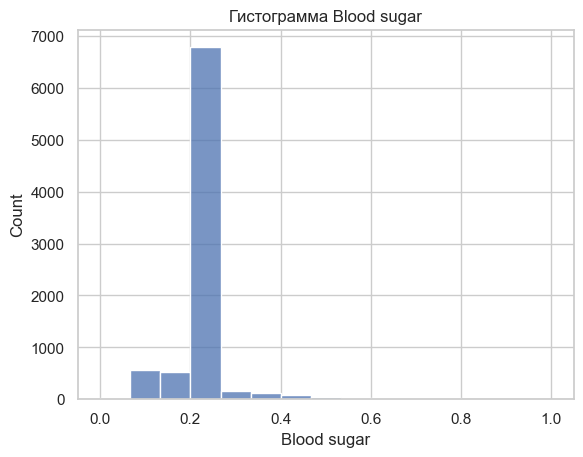

In [100]:
sns.histplot(heart_data, x='Blood sugar')
plt.title("Гистограмма Blood sugar")
plt.show()

In [101]:
heart_data.drop('Blood sugar', axis=1, inplace=True)

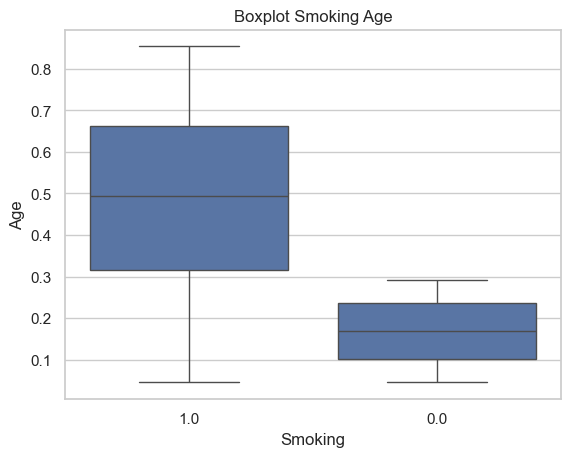

In [102]:
sns.set(style="whitegrid")

sns.boxplot(heart_data, x="Smoking", y="Age")
plt.title("Boxplot Smoking Age"); 
plt.xlabel("Smoking");
plt.show()

Отсюда мы видим, что курящие старше, у них возраст выше, в жизни это было бы немного логично, но данные синтетические, поэтому выводов пока не делаем

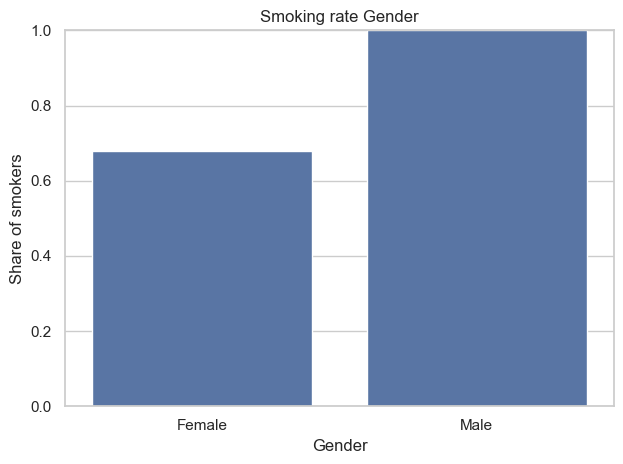

In [106]:
df = heart_data.copy()

df['Smoking'] = pd.to_numeric(df['Smoking'], errors='coerce')
df = df.dropna(subset=['Smoking'])
df['Smoking'] = (df['Smoking'] > 0.5).astype(int)

rate = df.groupby("Gender", as_index=False)["Smoking"].mean()
sns.barplot(data=rate, x="Gender", y="Smoking")
plt.title("Smoking rate Gender"); plt.ylabel("Share of smokers"); plt.ylim(0, 1)
plt.tight_layout(); plt.show()

Отсюда мы видим, что 100% мужчин и 70% женщин курят. Странный признак, поэтому предлагаю просто удалить признак Smoking

In [109]:
heart_data.drop('Smoking', axis=1, inplace=True)

interval columns not set, guessing: ['Age', 'Cholesterol', 'Heart rate', 'Exercise Hours Per Week', 'Stress Level', 'Sedentary Hours Per Day', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Heart Attack Risk (Binary)', 'Systolic blood pressure', 'Diastolic blood pressure']


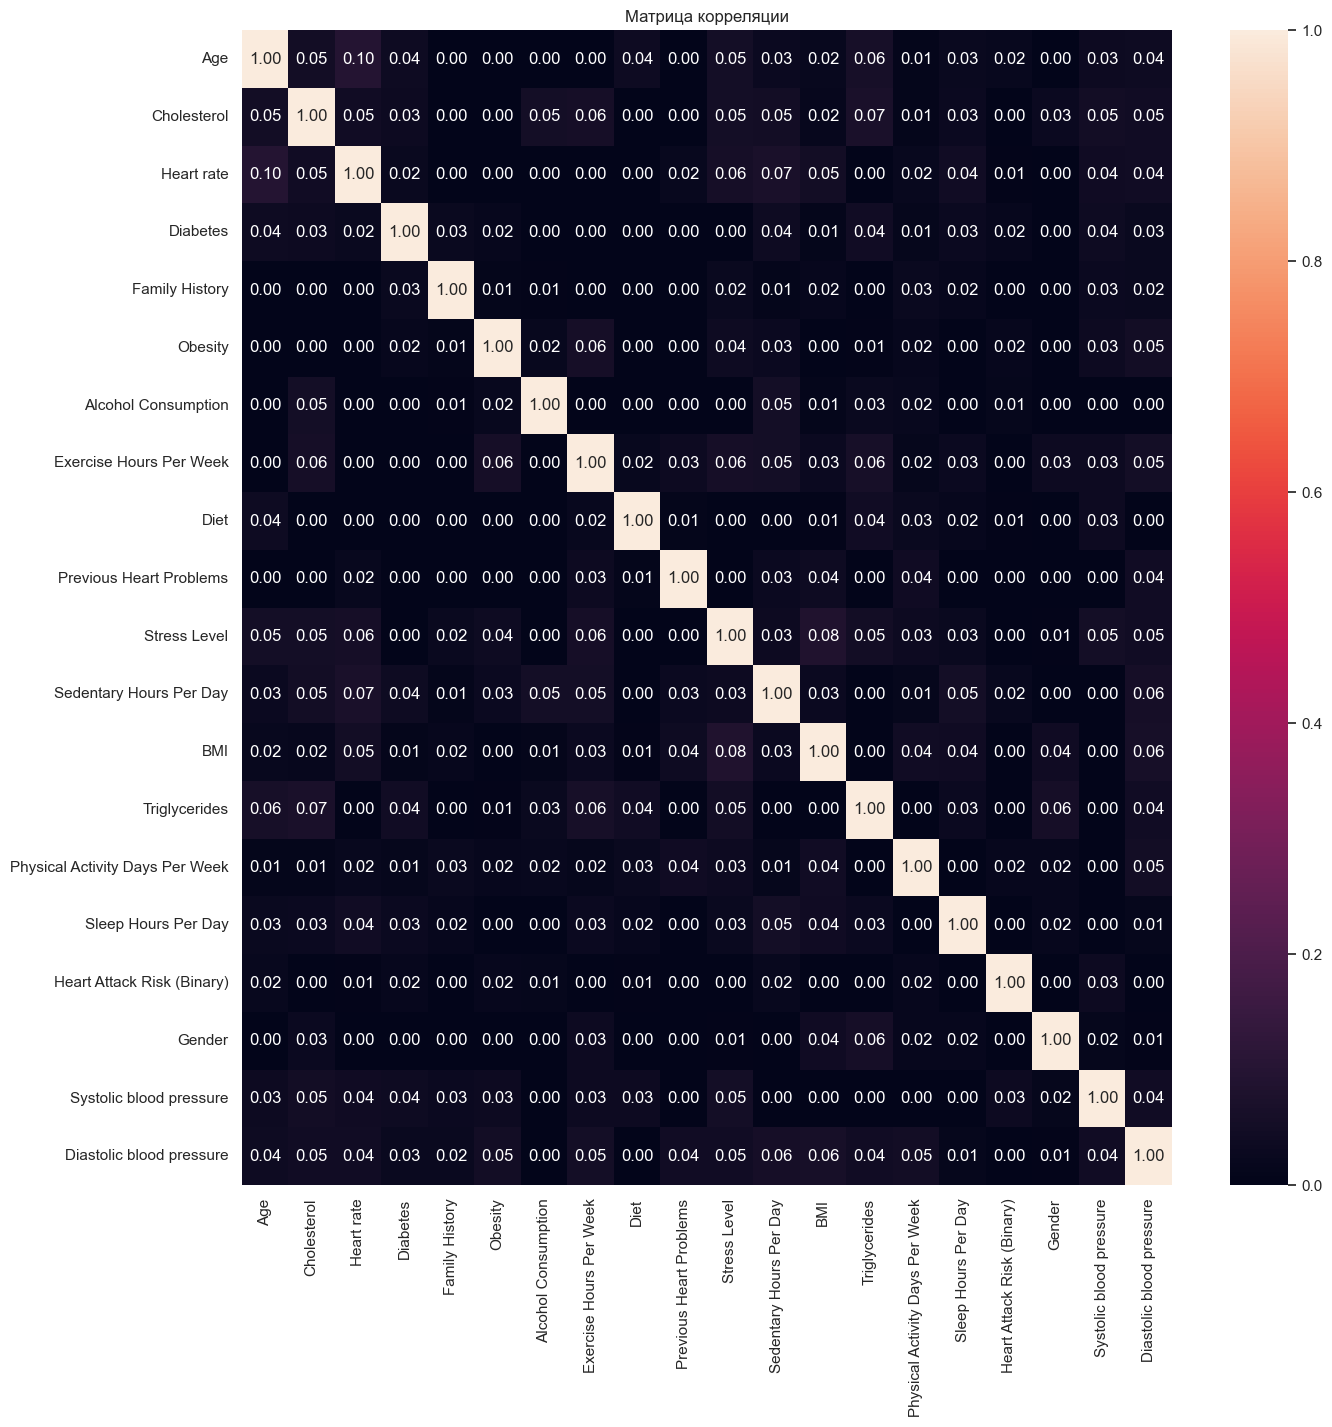

In [110]:
%matplotlib inline

corr_matrix = heart_data.phik_matrix()
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title('Матрица корреляции')
plt.show()

Линейных зависимости нет. Корреляция между признаками низкая. 

Будет очень тяжело получить хорошие результаты работы модели

### Разработка модели

In [279]:
X_train, X_test, y_train, y_test = train_test_split(
    heart_data.drop('Heart Attack Risk (Binary)', axis=1),
    heart_data['Heart Attack Risk (Binary)'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify = heart_data['Heart Attack Risk (Binary)']
)

In [280]:
pipe= Pipeline(
    [
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

In [281]:
param_distributions_cat = [
    # CatBoost
    {
        'models': [CatBoostClassifier(
            random_state=RANDOM_STATE,
            verbose=0,      # чтобы можно было использовать max_leaves
            # early_stopping_rounds=50,
            use_best_model=False, 
            auto_class_weights='Balanced',
            # cat_features=cat_idx
            # в CV без явного eval_set безопаснее False
        )],
        'models__iterations': range(100, 1000),
        'models__depth': range(4, 12),
        'models__l2_leaf_reg': range(1, 9),
    }
]


In [282]:
param_distributions = [
    {
        'models': [XGBClassifier(
            objective='binary:logistic',
            random_state=RANDOM_STATE,
            n_jobs=-1,
            tree_method='hist',
            eval_metric='logloss',
            scale_pos_weight=1.0
        )],
        'models__n_estimators': [400, 800, 1200],
        'models__max_depth': range(4, 15),
        'models__learning_rate': list(np.logspace(-3, -1, 8)),
        'models__subsample': [0.6, 0.75, 0.9, 1.0],
        'models__colsample_bytree': [0.6, 0.75, 0.9, 1.0],
        'models__min_child_weight': [1, 2, 5, 10],
        'models__gamma': [0, 0.1, 0.5, 1.0],
        'models__reg_alpha': [0.0, 0.1, 0.5, 1.0],
        'models__reg_lambda': [0.5, 1.0, 2.0, 5.0]
    },

    {
        'models': [RandomForestClassifier(
            class_weight='balanced',
            n_jobs=-1,
            random_state=RANDOM_STATE
        )],
        'models__n_estimators': range(400, 1200),
        'models__max_depth': range(4, 20),
        'models__min_samples_split': range(2, 10),
        'models__min_samples_leaf': range(1, 5),
        'models__max_features': ['sqrt', 'log2', None, 0.5, 0.7],
        'models__bootstrap': [True, False]
    },

    {
        'models': [GradientBoostingClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [300, 600, 1000],
        'models__learning_rate': list(np.logspace(-2, -0.3, 8)),
        'models__max_depth': [2, 3, 4],
        'models__subsample': [0.6, 0.75, 0.9, 1.0],
        'models__min_samples_split': [2, 5, 10],
        'models__min_samples_leaf': [1, 2, 5],
        'models__max_features': ['sqrt', None]
    },

    {
        'models': [LogisticRegression(
            class_weight='balanced',
            max_iter=3000,
            solver='saga',
            n_jobs=-1
        )],
        'models__penalty': ['l1', 'l2', 'elasticnet'],
        'models__C': list(np.logspace(-2, 2, 10)),
        'models__l1_ratio': [None, 0.0, 0.2, 0.5, 0.8, 1.0]
    },
    
    {
        'models': [SVC(
            kernel='rbf',
            probability=True,
            class_weight='balanced'
        )],
        'models__C': [0.5, 1, 2, 5],
        'models__gamma': ['scale', 0.01, 0.05, 0.1]
    },

    {
        'models': [DecisionTreeClassifier(
            random_state=RANDOM_STATE,
            class_weight='balanced'
        )],
        'models__max_depth': [None, 4, 6, 8, 12, 16],
        'models__min_samples_split': [2, 5, 10, 20],
        'models__min_samples_leaf': [1, 2, 5, 10],
    },
]


Для некоторых моделей из нашего перебора требуются инты, поэтому создадим отдельный X_train, в котором будет закодирован столбец Gender и в последствии все столбцы переведены к численному типу данных

In [283]:
X_train_rcv = X_train.copy()
X_test_rcv = X_test.copy()

In [284]:
X_train_rcv['Gender'].replace({'Male': 0, 'Female': 1}, inplace=True)
X_test_rcv['Gender'].replace({'Male': 0, 'Female': 1}, inplace=True)

C:\Users\and1kov\AppData\Local\Temp\ipykernel_15436\1925047064.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_rcv['Gender'].replace({'Male': 0, 'Female': 1}, inplace=True)
C:\Users\and1kov\AppData\Local\Temp\ipykernel_15436\1925047064.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

In [285]:
X_train_rcv['Gender'].unique()

array([0, 1, '0.0', '1.0'], dtype=object)

Также для катбуста сохраним ID категориальных признаков

In [286]:
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

In [287]:
cat_idx = X_train.columns.get_indexer(cat_cols)

В качестве метрики, по которой будем оценивать, возьмем average precision, поскольку у нас несбалансированные классы, из-за чего другие метрики будут завышены и из-за этого не будут в действительности отражать результаты

#### Построение модели

In [288]:
randomcv_cat_apr = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions_cat,
    n_iter=15,                 
    scoring='average_precision',             
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=2,
    return_train_score=False
)

In [289]:
randomcv_apr = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=15,
    scoring='average_precision',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=2,
    return_train_score=False
)

In [290]:
randomcv_cat_apr.fit(X_train, y_train, **{'models__cat_features': cat_idx})

Fitting 5 folds for each of 15 candidates, totalling 75 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('models',
                                              LogisticRegression(random_state=42))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions=[{'models': [<catboost.core.CatBoostClassifier object at 0x000001AD2E2DA140>],
                                         'models__depth': range(4, 12),
                                         'models__iterations': range(100, 1000),
                                         'models__l2_leaf_reg': range(1, 9)}],
                   random_state=42, scoring='average_precision', verbose=2)

In [291]:
def make_all_numeric(df): 
    for col in df.columns:
        if df[col].dtype.name == 'object':
            df[col] = df[col].astype('float')
    return df

In [292]:
X_train_rcv = make_all_numeric(X_train_rcv)
X_test_rcv = make_all_numeric(X_test_rcv)

In [293]:
randomcv_apr.fit(X_train_rcv, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('models',
                                              LogisticRegression(random_state=42))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions=[{'models': [XGBClassifier(base_score=None,
                                                                  booster=None,
                                                                  callbacks=None,
                                                                  colsample_bylevel=None,
                                                                  colsample_bynode=None,
                                                                  colsample_bytree=None,
                                                                  device=None,
                                                                  early_stopping_rounds=None,
                                                                  enable_categorical=False,
                                                                  eval_metri...
                                        {'models': [SVC(class_weight='balanced',
                                                        probability=True)],
                                         'models__C': [0.5, 1, 2, 5],
                                         'models__gamma': ['scale', 0.01, 0.05,
                                                           0.1]},
                                        {'models': [DecisionTreeClassifier(class_weight='balanced',
                                                                           random_state=42)],
                                         'models__max_depth': [None, 4, 6, 8,
                                                               12, 16],
                                         'models__min_samples_leaf': [1, 2, 5,
                                                                      10],
                                         'models__min_samples_split': [2, 5, 10,
                                                                       20]}],
                   random_state=42, scoring='average_precision', verbose=2)

Создадим функцию для отображения результатов

In [294]:
def get_results(fitted, X_test, y_test, name=''):
    best_pipe = fitted.best_estimator_
    y_pred = best_pipe.predict(X_test)
    best_model = best_pipe.named_steps['models']
    best_params = {k.replace('models__',''): v
                   for k, v in fitted.best_params_.items()
                   if k.startswith('models__')}
    print(name, '\n')
    print("МОДЕЛЬ:", type(best_model).__name__)
    print("ЛУЧШИЕ ПАРАМЕТРЫ:", best_params)
    print("ЛУЧШИЙ CV AUPRC:", f"{fitted.best_score_:.4f}")
    
    p_test = best_pipe.predict_proba(X_test)[:, 1]

    print("\nМетрики на тесте:")
    print("AUPRC   :", f"{average_precision_score(y_test, p_test):.4f}")
    print("ROC-AUC :", f"{roc_auc_score(y_test, p_test):.4f}")
    print('f1: 'f"{f1_score(y_test, y_pred)} \n")
    
    plt.figure(figsize=(5, 3))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
    plt.ylabel('Истинные значения')
    plt.xlabel('Предсказанные значения')
    plt.title('Матрица ошибок')
    plt.show()

CATBOOST на сырых данных 

МОДЕЛЬ: CatBoostClassifier
ЛУЧШИЕ ПАРАМЕТРЫ: {'l2_leaf_reg': 8, 'iterations': 592, 'depth': 11}
ЛУЧШИЙ CV AUPRC: 0.4723

Метрики на тесте:
AUPRC   : 0.4629
ROC-AUC : 0.5906
f1: 0.3512269938650307 



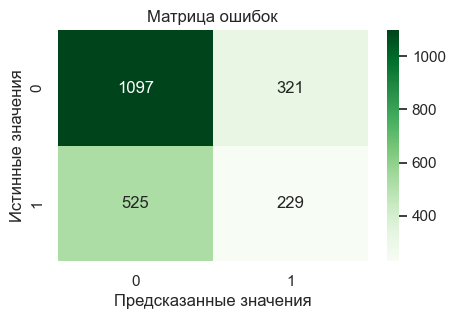

In [295]:
get_results(randomcv_cat_apr, X_test, y_test, 'CATBOOST на сырых данных')

ЛУЧШАЯ МОДЕЛЬ на сырых данных 

МОДЕЛЬ: RandomForestClassifier
ЛУЧШИЕ ПАРАМЕТРЫ: {'n_estimators': 745, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 13, 'bootstrap': True}
ЛУЧШИЙ CV AUPRC: 0.4717

Метрики на тесте:
AUPRC   : 0.4854
ROC-AUC : 0.6036
f1: 0.2728184553660983 



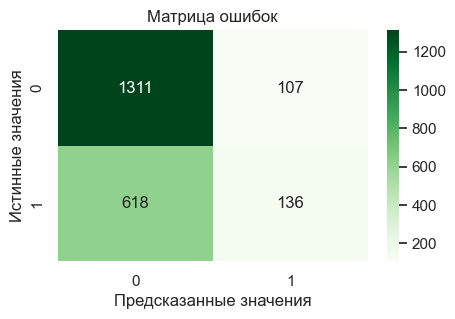

In [296]:
get_results(randomcv_apr, X_test_rcv, y_test, 'ЛУЧШАЯ МОДЕЛЬ на сырых данных')

Сохраним поиск для случайного леса

In [297]:
param_distributions_rf = [
    {
        'models': [RandomForestClassifier(
            class_weight='balanced',
            n_jobs=-1,
            random_state=RANDOM_STATE
        )],
        'models__n_estimators': range(400, 1200),
        'models__max_depth': range(4, 20),
        'models__min_samples_split': range(2, 10),
        'models__min_samples_leaf': range(1, 5),
        'models__max_features': ['sqrt', 'log2', None, 0.5, 0.7],
        'models__bootstrap': [True, False]
    }
]


### Выводы по моделям на сырых данных

Сравнивая модели, можно сказать, что catboost улавливает больше положительных результатов, но также у него больше ложноположительных результатов

RandomForest, в свою очередь, очень строгий. Мало ложноположительных ответов, но и меньше положительных результатов. Будем пробовать дальше


### Feature Engineering

Попробуем добавить новые фичи. Начнем 

In [298]:
Xtr = X_train.copy()
Xte = X_test.copy()

Xtr_rf = X_train_rcv.copy()
Xte_rf = X_test_rcv.copy()

In [299]:
def add_new_cols(data):
    df = data.copy()
    
    df['Mean Pressure'] = (df['Systolic blood pressure'] + (2 * df['Diastolic blood pressure'])) / 3
    df['Heart Mp'] = df['Heart rate'] / (df['Mean Pressure'] + 1e-6)
    df["PP_to_SBP"] = (df["Systolic blood pressure"] - df["Diastolic blood pressure"]) / (df["Systolic blood pressure"] + 1e-6)
                                           
    df["CHOLxTG"]   = df["Cholesterol"] * df["Triglycerides"]

    df["Exercise_per_Day"] = df["Exercise Hours Per Week"] / 7.0
    df["Sedentary_to_ActivityDays"] = df["Sedentary Hours Per Day"] / (df["Physical Activity Days Per Week"] + 1e-6)
    df["Stress_to_Sleep"] = df["Stress Level"] / (df["Sleep Hours Per Day"] + 1e-6)

    df['Age_BMI'] = df['Age'] * df['BMI']
    
    return df

In [300]:
Xtr = add_new_cols(Xtr)
Xte  = add_new_cols(Xte)

Xtr_rf = add_new_cols(Xtr_rf)
Xte_rf = add_new_cols(Xte_rf)

In [301]:
cat_cols_fe = Xtr.select_dtypes(include=['object']).columns.tolist()
cat_idx_fe  = cat_idx = Xtr.columns.get_indexer(cat_cols)

In [302]:
randomcv_cat_apr_fe = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions_cat,
    n_iter=15,
    scoring='average_precision',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=2,
    return_train_score=False
)

In [303]:
randomcv_cat_apr_fe.fit(Xtr, y_train, **{'models__cat_features': cat_idx_fe})

Fitting 5 folds for each of 15 candidates, totalling 75 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('models',
                                              LogisticRegression(random_state=42))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions=[{'models': [<catboost.core.CatBoostClassifier object at 0x000001AD2E2DA140>],
                                         'models__depth': range(4, 12),
                                         'models__iterations': range(100, 1000),
                                         'models__l2_leaf_reg': range(1, 9)}],
                   random_state=42, scoring='average_precision', verbose=2)

CATBOOST после добавления фичей 

МОДЕЛЬ: CatBoostClassifier
ЛУЧШИЕ ПАРАМЕТРЫ: {'l2_leaf_reg': 7, 'iterations': 852, 'depth': 11}
ЛУЧШИЙ CV AUPRC: 0.4644

Метрики на тесте:
AUPRC   : 0.4740
ROC-AUC : 0.5937
f1: 0.3459277917716205 



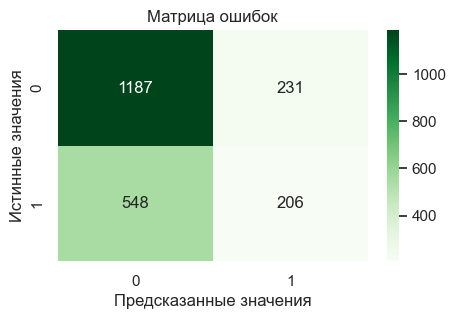

In [304]:
get_results(randomcv_cat_apr_fe, Xte, y_test, 'CATBOOST после добавления фичей')

In [305]:
# Имеются бесконечные значения, обработаем их
def simple_clean(df):
    d = df.copy()
    num_cols = d.select_dtypes(include=[np.number]).columns
    d[num_cols] = d[num_cols].replace([np.inf, -np.inf], np.nan)
    d[num_cols] = d[num_cols].fillna(d[num_cols].median(numeric_only=True))
    return d

In [306]:
Xtr_rf = simple_clean(Xtr_rf)
Xte_rf = simple_clean(Xte_rf)

In [307]:
randomcv_rf_epr_fe = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions_rf,
    n_iter=15,
    scoring='average_precision',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=2,
    return_train_score=False
)

In [308]:
randomcv_rf_epr_fe.fit(Xtr_rf, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('models',
                                              LogisticRegression(random_state=42))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions=[{'models': [RandomForestClassifier(class_weight='balanced',
                                                                           n_jobs=-1,
                                                                           random_state=42)],
                                         'models__bootstrap': [True, False],
                                         'models__max_depth': range(4, 20),
                                         'models__max_features': ['sqrt',
                                                                  'log2', None,
                                                                  0.5, 0.7],
                                         'models__min_samples_leaf': range(1, 5),
                                         'models__min_samples_split': range(2, 10),
                                         'models__n_estimators': range(400, 1200)}],
                   random_state=42, scoring='average_precision', verbose=2)

RANDOM FOREST после добавления фичей 

МОДЕЛЬ: RandomForestClassifier
ЛУЧШИЕ ПАРАМЕТРЫ: {'n_estimators': 474, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 19, 'bootstrap': True}
ЛУЧШИЙ CV AUPRC: 0.4686

Метрики на тесте:
AUPRC   : 0.4955
ROC-AUC : 0.6170
f1: 0.2092511013215859 



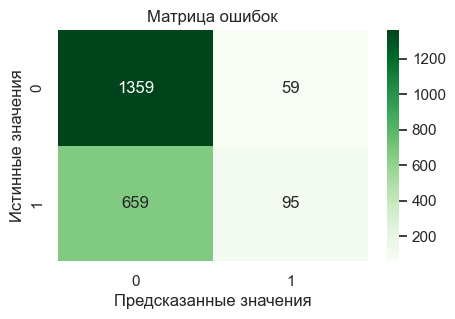

In [309]:
get_results(randomcv_rf_epr_fe, Xte_rf, y_test, 'RANDOM FOREST после добавления фичей')

Хоть метрики у Rf лучше (за ислкючением f1), но он меньше угадывает вероположительных ответов, это не подходит для нашей задачи, поэтому больше не рассматриваем случайный лес

Добавим еще фичей. Как я писал выше, можно признаки объединить в условные группы по типу активности образа жизни. Так и поступим

In [310]:
def min_max(x):
    return ((x - x.min()) / (x.max() - x.min()))

In [311]:
def add_drop_cols(df):
    d = df.copy()

    to_num = ["Alcohol Consumption","Obesity","Diet","Previous Heart Problems",
            "Exercise Hours Per Week","Physical Activity Days Per Week","Sedentary Hours Per Day",
            "Stress Level","Sleep Hours Per Day",'Family History', 'Diabetes'
    ]

    for c in to_num:
        if c in d.columns:
            d[c] = pd.to_numeric(d[c], errors="coerce")

    d[to_num] = d[to_num].astype('float')
    
    d['Lifestyle Index'] = d["Alcohol Consumption"] - d["Obesity"] - \
        d["Previous Heart Problems"] + ( 1 - min_max(d["Diet"]))
    
    d['Activity Index'] = min_max(d["Exercise Hours Per Week"]) + \
        min_max(d["Physical Activity Days Per Week"]) - \
        min_max(d["Sedentary Hours Per Day"])
    
    d["Stress Index"]   = min_max(d["Stress Level"]) - min_max(d["Sleep Hours Per Day"])

    d['Str Act Index'] = d['Activity Index'] * d['Stress Index']

    d['Health Index'] = d['Family History'] - d['Previous Heart Problems'] - \
        d['Diabetes'] + d['Activity Index']
    
    d = d.drop(columns=[c for c in to_num if c in d.columns])
    
    return d
    

In [312]:
Xtr_ff = add_drop_cols(Xtr)
Xte_ff = add_drop_cols(Xte)

In [313]:
cat_cols_ff = Xtr_ff.select_dtypes(include=['object']).columns.tolist()
cat_idx_ff  = cat_idx = Xtr_ff.columns.get_indexer(cat_cols_ff)

In [314]:
# dupe_idx = Xtr_ff.duplicated(keep='first')

# Xtr_ff = Xtr_ff.loc[~dupe_idx].reset_index(drop=True)
# y_train = y_train.loc[~dupe_idx].reset_index(drop=True)


In [315]:
randomcv_cat_ff = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions_cat,
    n_iter=15,
    scoring='average_precision',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=2,
    return_train_score=False
)

In [316]:
Xtr_ff.duplicated().sum()

np.int64(313)

In [317]:
randomcv_cat_ff.fit(Xtr_ff, y_train, **{'models__cat_features': cat_idx_ff})

Fitting 5 folds for each of 15 candidates, totalling 75 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('models',
                                              LogisticRegression(random_state=42))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions=[{'models': [<catboost.core.CatBoostClassifier object at 0x000001AD2E2DA140>],
                                         'models__depth': range(4, 12),
                                         'models__iterations': range(100, 1000),
                                         'models__l2_leaf_reg': range(1, 9)}],
                   random_state=42, scoring='average_precision', verbose=2)

CATBOOST после add_drop_cols 

МОДЕЛЬ: CatBoostClassifier
ЛУЧШИЕ ПАРАМЕТРЫ: {'l2_leaf_reg': 8, 'iterations': 592, 'depth': 11}
ЛУЧШИЙ CV AUPRC: 0.4707

Метрики на тесте:
AUPRC   : 0.4650
ROC-AUC : 0.5872
f1: 0.3295638126009693 



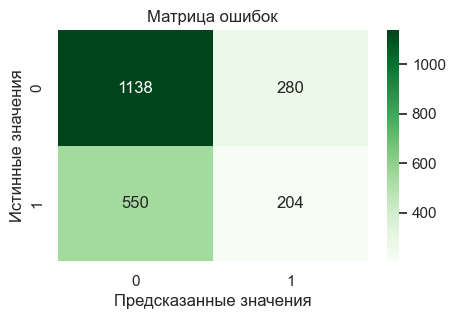

In [318]:
get_results(randomcv_cat_ff, Xte_ff, y_test, 'CATBOOST после add_drop_cols')

In [319]:
os.makedirs("artifacts", exist_ok=True)

joblib.dump(randomcv_cat_ff, "artifacts/best_pipeline.pkl")

['artifacts/best_pipeline.pkl']

### Выводы по моделям после добавления фичей

По метрикам AUPRC, ROC-AUC CatBoost лучше. Он более точный, что видно по матрице ошибок - он больше находит вероположительных ответов, при этом показывая хорошие метрики качества

### Порог классификации

In [334]:
y_pred_proba = randomcv_cat_ff.best_estimator_.predict_proba(Xte_ff)[:, 1]

threshold = np.arange(0.05, 1.00, 0.05)
rows = []

for ths in threshold:
    y_pred = y_pred_proba > ths
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    prec = tp / (tp + fp)
    rec  = tp / (tp + fn)
    f1   = f1_score(y_test, y_pred)
    acc  = (tp + tn) / (tp + tn + fp + fn)
    roc_auc = roc_auc_score(y_test, y_pred)

    rows.append([ths, prec, rec, f1, acc, roc_auc])

tbl = pd.DataFrame(rows, columns=["threshold","precision","recall","f1","accuracy",'roc-auc'])

tbl

,threshold,precision,recall,f1,accuracy,roc-auc
0,0.05,0.356839,1.000000,0.525985,0.374309,0.520804
1,0.10,0.361631,1.000000,0.531173,0.387201,0.530677
2,0.15,0.366536,0.990716,0.535100,0.402394,0.540139
3,0.20,0.373134,0.961538,0.537634,0.425875,0.551291
4,0.25,0.374080,0.876658,0.524395,0.447974,0.548343
5,0.30,0.377457,0.763926,0.505263,0.480663,0.546984
6,0.35,0.387046,0.649867,0.485149,0.521179,0.551309
7,0.40,0.404472,0.527851,0.457998,0.566298,0.557297
8,0.45,0.407713,0.392573,0.400000,0.591160,0.544664
9,0.50,0.421488,0.270557,0.329564,0.617864,0.536548


Следует обратить внимание на порог 0.25, поскольку при этом пороге по сравнению с предыдущим несильно уменьшается precision, сильно взлетает recall, практически до максимума улучшается f1, и немного падает accuracy

In [343]:
y_pred = (y_pred_proba >= 0.25).astype(int)

confusion_matrix(y_test, y_pred, labels=[0, 1])

array([[ 312, 1106],
       [  93,  661]])

### Вывод

<b> EDA </b>

- Обнаружили, что данные синтетические
- Убрали учетку данных за счет удаления признаков CK-MB и Troponin
- Также убрали странные blood sugar и Smoking

<b> Предобработка </b>

- Были изменены типы данных
- Пропуски были заменены медианными значениями

<b> Обучение моделей </b>

В ходе обучения взяли 2 модели - catboost и random forest classifier за отправную точку

После добавления новых признаков улучшились метрики, но было принято решение остановиться только на catboost, поскольку он показывал результаты, более подходящие бизнесу

Выбрали за главную метрику - AUPRC из-за дисбаланса классов 

После обучения подобрали порог классфикации - 0.25, при котором создается компромисс между верноположительными и ложноположительными ответами